### KC Electra model 및 Electra model 사용

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

import warnings
warnings.filterwarnings("ignore")

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

seed = 42
my_seed_everywhere(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/NLP/train.csv'
data = pd.read_csv(data_path)

test_path = '/content/drive/MyDrive/NLP/test.csv'
test = pd.read_csv(test_path)

In [ ]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

data = data.replace(label_dict)

In [ ]:
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,1
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,0
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",0
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,0


In [ ]:
# data['text'] = data['text'].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl=r'', regex=True)
# test['text'] = test['text'].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl=r'', regex=True)

In [ ]:
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,1
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,0
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",0
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,0


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda:0


In [ ]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=5)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.weight', 'classifi

In [ ]:
target = 'label'
x = data.drop(target, axis=1, inplace=False)
y = data.loc[:,target]

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2023, stratify=y)

In [ ]:
tokenized_train_sentences = tokenizer(
    list(x_train["text"]),
    return_tensors="pt",                # pytorch의 tensor 형태로 return
    max_length=150,                     # 최대 토큰길이 설정
    padding=True,                       # 제로패딩 설정
    truncation=True,                    # max_length 초과 토큰 truncate
    add_special_tokens=True,            # special token 추가
    )

In [ ]:

tokenized_test_sentences = tokenizer(
    list(x_test["text"]),
    return_tensors="pt",
    max_length=150,
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [ ]:
class Q_Ko_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
Y_train = y_train.values

In [ ]:
Y_test = y_test.values

In [ ]:
train_dataset = Q_Ko_Dataset(tokenized_train_sentences, Y_train)
test_dataset = Q_Ko_Dataset(tokenized_test_sentences, Y_test)

In [ ]:
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NLP/KoELECTRA_model_full',                    # 학습결과 저장경로
    num_train_epochs=50,                # 학습 epoch 설정
    per_device_train_batch_size=32,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='./logs',               # 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from transformers import Trainer

In [ ]:
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.486200
1000,0.051200
1500,0.015100
2000,0.006700
2500,0.004600
3000,0.000800
3500,0.000800
4000,0.000400


TrainOutput(global_step=4100, training_loss=0.06900625058324872, metrics={'train_runtime': 867.3547, 'train_samples_per_second': 149.535, 'train_steps_per_second': 4.727, 'total_flos': 9997975511010000.0, 'train_loss': 0.06900625058324872, 'epoch': 50.0})

In [ ]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 1.6535773277282715,
 'eval_accuracy': 0.8273381294964028,
 'eval_f1': 0.837327383324123,
 'eval_precision': 0.8213607727966009,
 'eval_recall': 0.8574894695159131,
 'eval_runtime': 2.2728,
 'eval_samples_per_second': 489.271,
 'eval_steps_per_second': 15.4,
 'epoch': 50.0}

In [ ]:
c = test.copy()

In [ ]:
torch_tensor = torch.tensor(targets_df['targets'].values)

In [ ]:
model.to('cpu')

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
model.eval()
result = []
for i in range(len(test)):
        
    temp = model(**tokenizer(test["text"][i],
                             return_tensors="pt",
                             max_length=200,
                             padding=True,
                             truncation=True,
                             add_special_tokens=True))
    logits = temp.logits
    preds = logits.argmax(dim=-1)
    if preds == 0:
        result.append(0)
    elif preds == 1:
        result.append(1)
    elif preds == 2:
        result.append(2)
    elif preds == 3:
        result.append(3)
    elif preds == 4:
        result.append(4)

print(result)

[3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 0, 2, 3, 2, 4, 4, 0, 0, 2, 0, 2, 0, 0, 1, 0, 3, 3, 2, 0, 3, 2, 0, 0, 0, 0, 0, 1, 0, 0, 3, 2, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 3, 0, 2, 0, 0, 0, 3, 3, 3, 0, 0, 0, 1, 1, 0, 0, 0, 3, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 3, 1, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 3, 3, 2, 0, 3, 3, 0, 2, 3, 2, 0, 2, 0, 0, 0, 4, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 2, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 4, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 2, 2, 0, 3, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 0, 2, 2, 0, 0, 2, 3, 3, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 

In [ ]:
result = pd.Series(result)

In [ ]:
final = pd.DataFrame({
    'label' : result
})

In [ ]:
final.head()

,label
0,3
1,3
2,0
3,0
4,0


In [ ]:
final = final.reset_index()
final.rename(columns={
    'index' : 'id'
}, inplace=True)

In [ ]:
final.head()

,id,label
0,0,3
1,1,3
2,2,0
3,3,0
4,4,0


In [ ]:
final.to_csv('/content/drive/MyDrive/NLP/submission2.csv', index=False)

In [ ]:
final.to_csv('/content/drive/MyDrive/NLP/submission.csv', index=False)

In [ ]:
final.to_csv('/content/drive/MyDrive/NLP/submisson3.csv', index=False)

### koBert

In [ ]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time
import datetime

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Bert 용 전처리 -1)
train_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_train]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_train = [tokenizer.tokenize(s) for s in train_sentences]
ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]

In [ ]:
val_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_val]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_val = [tokenizer.tokenize(s) for s in val_sentences]
ids_val = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_val]

In [ ]:
test_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_test]
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_test = [tokenizer.tokenize(s) for s in test_sentences]
ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]

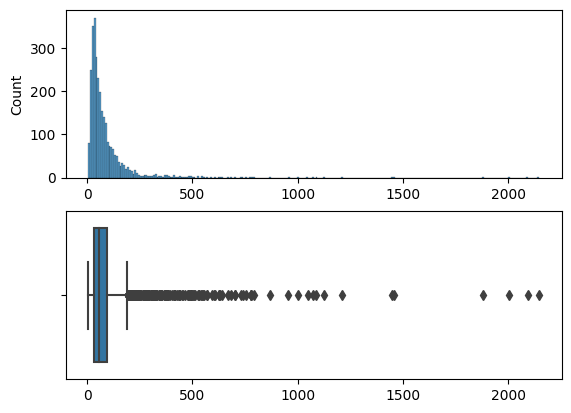

count    2964.000000
mean       88.791498
std       130.703681
min         5.000000
25%        33.000000
50%        54.000000
75%        96.250000
max      2146.000000
dtype: float64

In [ ]:
temp = [len(x) for x in ids_train]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

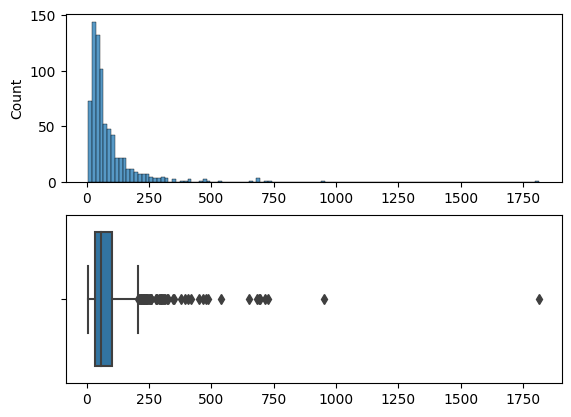

count     742.000000
mean       87.788410
std       116.584651
min         6.000000
25%        32.000000
50%        55.500000
75%       101.750000
max      1815.000000
dtype: float64

In [ ]:
temp = [len(x) for x in ids_val]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

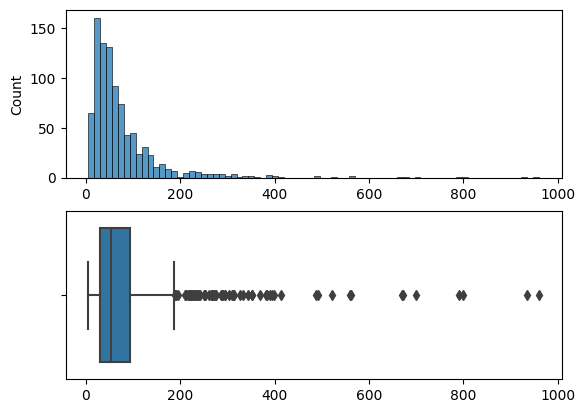

count    929.000000
mean      80.620022
std       96.438300
min        5.000000
25%       31.000000
50%       53.000000
75%       93.000000
max      961.000000
dtype: float64

In [ ]:
temp = [len(x) for x in ids_test]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

In [ ]:
MAX_LEN = 200 # 최대 길이
pad_train = pad_sequences(
    ids_train, maxlen=MAX_LEN, dtype="long", padding="post", truncating="post"
)

In [ ]:
pad_train.shape

(2964, 200)

In [ ]:
MAX_LEN = 200 # 최대 길이
pad_test = pad_sequences(
    ids_test, maxlen=MAX_LEN, dtype="long", padding="post", truncating="post"
)

In [ ]:
y_train.values[:3]

array([0, 2, 2])

In [ ]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_train, y_train.values, random_state=2023, test_size=0.1)

In [ ]:
train_inputs.shape, val_inputs.shape

((2667, 200), (297, 200))

In [ ]:
test_inputs = pad_test

In [ ]:
# Attention Mask 만들기
# 단어 부분은 1, 0으로 패딩된 부분은 0
attention_masks_train = []
for seq in train_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_train.append(seq_mask)

attention_masks_val = []
for seq in val_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_val.append(seq_mask)

attention_masks_test = []
for seq in test_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_test.append(seq_mask)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(attention_masks_train)
train_labels = torch.tensor(train_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(attention_masks_val)
val_labels = torch.tensor(val_labels)

test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# test_set

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# GPU 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# 옵티마이저
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률(learning rate)
                  eps = 1e-8 
                )

# 에폭수
epochs = 100

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 시각화를 위한 결과 값 저장
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

## Early Stopping
best_loss = 1e9
best_acc = 0  
patience_limit = 7  # 몇 번 지켜볼지
patience_check = 0   # 현재 몇 epoch 연속으로 개선이 안되는지 기록

#그래디언트 초기화
model.zero_grad()

# 학습
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()


    # 훈련모드로 변경
    model.train()
    
    # 변수 초기화
    train_accuracy, nb_train_steps = 0, 0
    # 로스 초기화
    total_loss = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm_notebook(train_dataloader)):
        # 경과 정보 표시
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        logits = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)
    
    # 평균 정확도 계산
    avg_train_acc = train_accuracy/nb_train_steps
    train_acc_list.append(avg_train_acc)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.4f}".format(avg_train_acc))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    val_loss, val_accuracy = 0, 0
    nb_val_steps =  0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in tqdm_notebook(val_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        # 출력 로짓 구함
        logits = outputs[1]

        # 총 로스 계산
        val_loss += loss.item()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_val_accuracy = flat_accuracy(logits, label_ids)
        val_accuracy += tmp_val_accuracy
        nb_val_steps += 1

    # 평균 로스 계산
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_list.append(avg_val_loss)
    
    # 평균 정확도 계산
    avg_val_acc = val_accuracy/nb_val_steps
    val_acc_list.append(avg_val_acc)
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation Accuracy: {0:.4f}".format(avg_val_acc))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Early Stopping
    if avg_val_loss > best_loss: # loss 개선 되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit:
            print("Early Stopping !!!")
            break
    else: # loss 개선
        best_loss = avg_val_loss
        patience_check = 0
    # # Early Stopping
    # if avg_val_acc < best_acc: # accuracy 개선 되지 않은 경우
    #     patience_check += 1
    #     if patience_check >= patience_limit:
    #         print("Early Stopping !!!")
    #         break
    # else: # accuracy 개선
    #     best_acc = avg_val_acc
    #     patience_check = 0

print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:15.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.9516
  Average training accuracy: 0.6363
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.6020
  Validation Accuracy: 0.8132
  Validation took: 0:00:01

======== Epoch 2 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.4703
  Average training accuracy: 0.8473
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.5796
  Validation Accuracy: 0.7562
  Validation took: 0:00:01

======== Epoch 3 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.2691
  Average training accuracy: 0.9175
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.5447
  Validation Accuracy: 0.7982
  Validation took: 0:00:01

======== Epoch 4 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.1582
  Average training accuracy: 0.9566
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.4466
  Validation Accuracy: 0.8732
  Validation took: 0:00:01

======== Epoch 5 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0748
  Average training accuracy: 0.9813
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.6251
  Validation Accuracy: 0.8659
  Validation took: 0:00:01

======== Epoch 6 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0476
  Average training accuracy: 0.9884
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.6991
  Validation Accuracy: 0.8593
  Validation took: 0:00:01

======== Epoch 7 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0272
  Average training accuracy: 0.9936
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.7672
  Validation Accuracy: 0.8626
  Validation took: 0:00:01

======== Epoch 8 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0178
  Average training accuracy: 0.9963
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.9776
  Validation Accuracy: 0.8344
  Validation took: 0:00:01

======== Epoch 9 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0160
  Average training accuracy: 0.9955
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.8567
  Validation Accuracy: 0.8454
  Validation took: 0:00:01

======== Epoch 10 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0079
  Average training accuracy: 0.9974
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 1.0046
  Validation Accuracy: 0.8586
  Validation took: 0:00:01

======== Epoch 11 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:03.
  Batch    40  of    167.    Elapsed: 0:00:06.
  Batch    60  of    167.    Elapsed: 0:00:09.
  Batch    80  of    167.    Elapsed: 0:00:12.
  Batch   100  of    167.    Elapsed: 0:00:14.
  Batch   120  of    167.    Elapsed: 0:00:17.
  Batch   140  of    167.    Elapsed: 0:00:20.
  Batch   160  of    167.    Elapsed: 0:00:23.

  Average training loss: 0.0047
  Average training accuracy: 0.9985
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 1.0184
  Validation Accuracy: 0.8363
  Validation took: 0:00:01
Early Stopping !!!

Training complete!


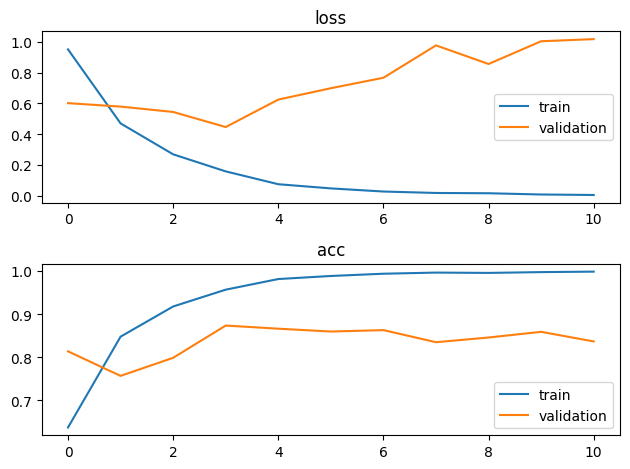

In [ ]:
plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('acc')
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='validation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## Test Set
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(val_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 출력 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.84
Test took: 0:00:01


In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):
    # [CLS] + 문장 + [SEP]
    sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 200

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

def test_sentences(sentences):
    result = []
    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 출력 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    
    return logits

In [ ]:
y_pred = test_sentences(x_test)

In [ ]:
len(y_pred)

929

In [ ]:
result = []
for i in range(len(y_pred)):
  preds = y_pred[i].argmax(-1)
  if preds == 0:
    result.append(0)
  elif preds == 1:
    result.append(1)
  elif preds == 2:
    result.append(2)
  elif preds == 3:
    result.append(3)
  elif preds == 4:
    result.append(4)
print(result)

[3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 4, 4, 0, 0, 2, 0, 2, 0, 0, 0, 0, 3, 3, 2, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 3, 2, 2, 2, 3, 3, 0, 2, 2, 0, 0, 3, 2, 2, 2, 3, 2, 0, 2, 3, 2, 0, 2, 0, 0, 0, 4, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 3, 2, 2, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 0, 2, 2, 0, 0, 2, 3, 3, 2, 2, 2, 0, 0, 0, 2, 0, 0, 3, 

In [ ]:
a = pd.Series(result)

In [ ]:
final = pd.DataFrame(
    
)

In [ ]:
final['label'] = a

In [ ]:
final = final.reset_index()

In [ ]:
final.to_csv('/content/drive/MyDrive/NLP/final.csv', index=False)

In [ ]:
final = pd.read_csv('/content/drive/MyDrive/NLP/final.csv')

In [ ]:
final.rename(columns={
    'index': 'id'
}, inplace=True)

In [ ]:
final.head()

,id,label
0,0,3
1,1,2
2,2,0
3,3,0
4,4,0


In [ ]:
final.to_csv('/content/drive/MyDrive/NLP/final22.csv', index=False)

In [ ]:
y_pred[0]

array([-1.9973967, -2.2015352, -1.2722874,  7.970508 , -1.4657362],
      dtype=float32)

### Bert모델 fine tuning

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 200, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
a = [labels[label] for label in df['category']]
print(a)

[0, 1, 0, 0, 0, 2, 1, 2, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 1, 3, 0, 1, 3, 4, 3, 0, 0, 2, 0, 2, 0, 1, 1, 1, 1, 3, 0, 3, 0, 2, 2, 3, 1, 0, 0, 1, 4, 0, 2, 2, 1, 0, 2, 3, 0, 4, 0, 0, 2, 0, 1, 3, 2, 0, 1, 0, 2, 2, 0, 3, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 3, 2, 3, 0, 2, 2, 0, 4, 3, 1, 3, 0, 0, 2, 1, 3, 1, 2, 1, 3, 0, 3, 0, 2, 2, 2, 1, 0, 3, 2, 2, 3, 1, 2, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 2, 2, 0, 0, 2, 3, 2, 3, 1, 1, 2, 0, 0, 3, 1, 1, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 0, 3, 3, 0, 3, 0, 2, 3, 0, 3, 0, 2, 1, 0, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 2, 2, 1, 0, 1, 2, 0, 3, 0, 0, 3, 3, 1, 3, 3, 2, 1, 3, 0, 0, 3, 3, 3, 3, 3, 2, 3, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 2, 2, 0, 0, 4, 0, 1, 0, 3, 2, 2, 1, 1, 0, 0, 3, 2, 0, 2, 0, 0, 3, 0, 0, 1, 3, 3, 3, 3, 1, 1, 2, 0, 0, 0, 0, 1, 3, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 2, 3, 0, 0, 0, 1, 1, 3, 1, 2, 0, 1, 0, 2, 2, 2, 4, 

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate, eps=1e-8)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

2964 371 371


In [ ]:
EPOCHS = 30
model = BertClassifier()
LR = 2e-5
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1482/1482 [00:57<00:00, 25.84it/s]


Epochs: 1 | Train Loss:  0.495                 | Train Accuracy:  0.647                 | Val Loss:  0.334                 | Val Accuracy:  0.787


100%|██████████| 1482/1482 [00:57<00:00, 25.68it/s]


Epochs: 2 | Train Loss:  0.227                 | Train Accuracy:  0.854                 | Val Loss:  0.237                 | Val Accuracy:  0.857


100%|██████████| 1482/1482 [00:56<00:00, 26.46it/s]


Epochs: 3 | Train Loss:  0.104                 | Train Accuracy:  0.942                 | Val Loss:  0.271                 | Val Accuracy:  0.846


100%|██████████| 1482/1482 [00:56<00:00, 26.03it/s]


Epochs: 4 | Train Loss:  0.043                 | Train Accuracy:  0.975                 | Val Loss:  0.376                 | Val Accuracy:  0.817


100%|██████████| 1482/1482 [00:56<00:00, 26.20it/s]


Epochs: 5 | Train Loss:  0.040                 | Train Accuracy:  0.980                 | Val Loss:  0.331                 | Val Accuracy:  0.852


100%|██████████| 1482/1482 [00:56<00:00, 26.09it/s]


Epochs: 6 | Train Loss:  0.038                 | Train Accuracy:  0.981                 | Val Loss:  0.328                 | Val Accuracy:  0.836


100%|██████████| 1482/1482 [00:56<00:00, 26.44it/s]


Epochs: 7 | Train Loss:  0.022                 | Train Accuracy:  0.990                 | Val Loss:  0.356                 | Val Accuracy:  0.849


100%|██████████| 1482/1482 [00:57<00:00, 25.89it/s]


Epochs: 8 | Train Loss:  0.015                 | Train Accuracy:  0.994                 | Val Loss:  0.416                 | Val Accuracy:  0.833


100%|██████████| 1482/1482 [00:55<00:00, 26.47it/s]


Epochs: 9 | Train Loss:  0.027                 | Train Accuracy:  0.984                 | Val Loss:  0.465                 | Val Accuracy:  0.825


100%|██████████| 1482/1482 [00:56<00:00, 26.05it/s]


Epochs: 10 | Train Loss:  0.029                 | Train Accuracy:  0.987                 | Val Loss:  0.427                 | Val Accuracy:  0.811


100%|██████████| 1482/1482 [00:56<00:00, 26.21it/s]


Epochs: 11 | Train Loss:  0.022                 | Train Accuracy:  0.987                 | Val Loss:  0.425                 | Val Accuracy:  0.819


100%|██████████| 1482/1482 [00:56<00:00, 26.23it/s]


Epochs: 12 | Train Loss:  0.015                 | Train Accuracy:  0.991                 | Val Loss:  0.452                 | Val Accuracy:  0.830


100%|██████████| 1482/1482 [00:55<00:00, 26.47it/s]


Epochs: 13 | Train Loss:  0.014                 | Train Accuracy:  0.991                 | Val Loss:  0.433                 | Val Accuracy:  0.830


100%|██████████| 1482/1482 [00:56<00:00, 26.06it/s]


Epochs: 14 | Train Loss:  0.022                 | Train Accuracy:  0.989                 | Val Loss:  0.557                 | Val Accuracy:  0.814


100%|██████████| 1482/1482 [00:56<00:00, 26.29it/s]


Epochs: 15 | Train Loss:  0.019                 | Train Accuracy:  0.989                 | Val Loss:  0.464                 | Val Accuracy:  0.830


100%|██████████| 1482/1482 [00:56<00:00, 26.18it/s]


Epochs: 16 | Train Loss:  0.017                 | Train Accuracy:  0.989                 | Val Loss:  0.483                 | Val Accuracy:  0.825


100%|██████████| 1482/1482 [00:56<00:00, 26.35it/s]


Epochs: 17 | Train Loss:  0.008                 | Train Accuracy:  0.996                 | Val Loss:  0.507                 | Val Accuracy:  0.814


100%|██████████| 1482/1482 [00:56<00:00, 26.26it/s]


Epochs: 18 | Train Loss:  0.009                 | Train Accuracy:  0.996                 | Val Loss:  0.390                 | Val Accuracy:  0.857


100%|██████████| 1482/1482 [00:56<00:00, 26.39it/s]


Epochs: 19 | Train Loss:  0.010                 | Train Accuracy:  0.995                 | Val Loss:  0.490                 | Val Accuracy:  0.819


100%|██████████| 1482/1482 [00:56<00:00, 26.45it/s]


Epochs: 20 | Train Loss:  0.024                 | Train Accuracy:  0.988                 | Val Loss:  0.435                 | Val Accuracy:  0.836


100%|██████████| 1482/1482 [00:57<00:00, 25.87it/s]


Epochs: 21 | Train Loss:  0.013                 | Train Accuracy:  0.993                 | Val Loss:  0.589                 | Val Accuracy:  0.782


100%|██████████| 1482/1482 [00:56<00:00, 26.46it/s]


Epochs: 22 | Train Loss:  0.009                 | Train Accuracy:  0.995                 | Val Loss:  0.541                 | Val Accuracy:  0.827


100%|██████████| 1482/1482 [00:56<00:00, 26.25it/s]


Epochs: 23 | Train Loss:  0.005                 | Train Accuracy:  0.998                 | Val Loss:  0.518                 | Val Accuracy:  0.830


100%|██████████| 1482/1482 [00:56<00:00, 26.24it/s]


Epochs: 24 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.558                 | Val Accuracy:  0.841


100%|██████████| 1482/1482 [00:57<00:00, 25.83it/s]


Epochs: 25 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.580                 | Val Accuracy:  0.841


100%|██████████| 1482/1482 [00:56<00:00, 26.43it/s]


Epochs: 26 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.609                 | Val Accuracy:  0.841


100%|██████████| 1482/1482 [00:57<00:00, 25.83it/s]


Epochs: 27 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.643                 | Val Accuracy:  0.838


100%|██████████| 1482/1482 [00:56<00:00, 26.41it/s]


Epochs: 28 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.676                 | Val Accuracy:  0.841


100%|██████████| 1482/1482 [00:56<00:00, 26.25it/s]


Epochs: 29 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.722                 | Val Accuracy:  0.836


100%|██████████| 1482/1482 [00:57<00:00, 25.82it/s]


Epochs: 30 | Train Loss:  0.022                 | Train Accuracy:  0.988                 | Val Loss:  0.462                 | Val Accuracy:  0.822


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/NLP/english_test.csv')
test.head()

,id,text
0,0,I'm trying to access Timz with a laptop and us...
1,1,Is the score received in the self-test a facto...
2,2,Enter a = int ('input') value of integer A.:')...
3,3,"def max4(a,b,c,d):\n maximum = a\n if b&..."
4,4,I don't understand why i**=2 is the same as i*...


In [ ]:
test['text'] = test['text'].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl=r'', regex=True)
import re
test['text'] = test['text'].apply(lambda x: re.sub('\s+', ' ', x))
test['text'] = test['text'].apply(lambda x: re.sub('\.+', '.', x))

In [ ]:
df_test

,text,category
1603,"# Remove missing values bike[[['Motor','Carbon...",코드2
160,"As you suggested, I changed df_1 = df.copy() o...",시스템 운영
1704,"Hello, I have a question during the f-string p...",코드1
956,# Add Columns pop['k_total'] = pop['k_male'] +...,코드2
3234,The internet speed is too slow and I couldn't ...,코드2
...,...,...
1130,Do I only need to fill out the flow chart like...,이론
1294,"Listening to today's lecture, I'm so happy tha...",이론
860,If the data I'm using tomorrow does not overla...,시스템 운영
3507,seoul_moving['start']=seoul_moving['start city...,코드2


In [ ]:
x_train = df_train['text']
y_train = df_train['label']

x_val = df_val['text']
y_val = df_val['label']

x_test = df_test['text']
y_test = df_test['label']

In [ ]:
train_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_train]
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
tokenized_train = [tokenizer.tokenize(s) for s in train_sentences]
ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]

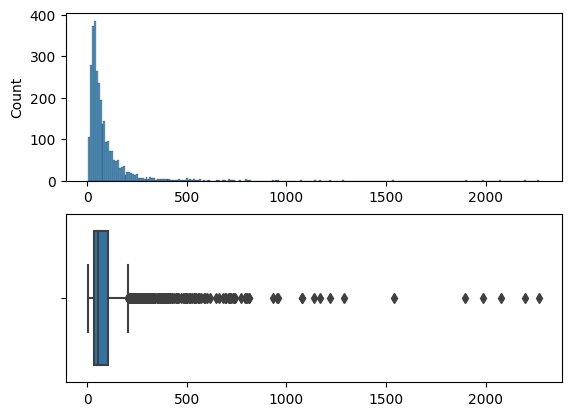

count    2964.000000
mean       93.066464
std       141.054256
min         5.000000
25%        33.000000
50%        55.500000
75%       102.000000
max      2268.000000
dtype: float64

In [ ]:
temp = [len(x) for x in ids_train]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

In [ ]:
MAX_LEN = 200 # 최대 길이
pad_train = pad_sequences(
    ids_train, maxlen=MAX_LEN, dtype="long", padding="post", truncating="post"
)

In [ ]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_train, y_train.values, random_state=2023, test_size=0.1)

In [ ]:
# Attention Mask 만들기
# 단어 부분은 1, 0으로 패딩된 부분은 0
attention_masks_train = []
for seq in train_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_train.append(seq_mask)

attention_masks_val = []
for seq in val_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_val.append(seq_mask)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(attention_masks_train)
train_labels = torch.tensor(train_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(attention_masks_val)
val_labels = torch.tensor(val_labels)

In [ ]:
batch_size = 2
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
## Test Set 전처리

# [CLS] + 문장 + [SEP]
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in x_test]

# 라벨 데이터
labels = y_test.values

# Word 토크나이저 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 시퀀스 설정 및 정수 인덱스 변환 & 패딩
MAX_LEN = 200
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# 파이토치 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈 설정 및 데이터 설정
batch_size = 2
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# GPU 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask, token_type_ids, labels):

        _, pooled_output = self.bert(input_ids= input_id, token_type_ids = token_type_ids, attention_mask=mask, labels=labels,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
model = BertClassifier()
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
# 옵티마이저
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률(learning rate)
                  eps = 1e-8 
                )

# 에폭수
epochs = 100

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 시각화를 위한 결과 값 저장
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

## Early Stopping
best_loss = 1e9
best_acc = 0  
patience_limit = 7  # 몇 번 지켜볼지
patience_check = 0   # 현재 몇 epoch 연속으로 개선이 안되는지 기록

#그래디언트 초기화
model.zero_grad()

# 학습
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()


    # 훈련모드로 변경
    model.train()
    
    # 변수 초기화
    train_accuracy, nb_train_steps = 0, 0
    # 로스 초기화
    total_loss = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm_notebook(train_dataloader)):
        # 경과 정보 표시
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(input_id = b_input_ids,
                          
                        mask = b_input_mask,
                        token_type_ids =None, 
                        )
        
        # 로스 구함
        loss = outputs[0]
        logits = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)
    
    # 평균 정확도 계산
    avg_train_acc = train_accuracy/nb_train_steps
    train_acc_list.append(avg_train_acc)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.4f}".format(avg_train_acc))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    val_loss, val_accuracy = 0, 0
    nb_val_steps =  0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in tqdm_notebook(val_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        # 출력 로짓 구함
        logits = outputs[1]

        # 총 로스 계산
        val_loss += loss.item()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_val_accuracy = flat_accuracy(logits, label_ids)
        val_accuracy += tmp_val_accuracy
        nb_val_steps += 1

    # 평균 로스 계산
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_list.append(avg_val_loss)
    
    # 평균 정확도 계산
    avg_val_acc = val_accuracy/nb_val_steps
    val_acc_list.append(avg_val_acc)
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation Accuracy: {0:.4f}".format(avg_val_acc))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Early Stopping
    if avg_val_loss > best_loss: # loss 개선 되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit:
            print("Early Stopping !!!")
            break
    else: # loss 개선
        best_loss = avg_val_loss
        patience_check = 0
    # # Early Stopping
    # if avg_val_acc < best_acc: # accuracy 개선 되지 않은 경우
    #     patience_check += 1
    #     if patience_check >= patience_limit:
    #         print("Early Stopping !!!")
    #         break
    # else: # accuracy 개선
    #     best_acc = avg_val_acc
    #     patience_check = 0

print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...


  0%|          | 0/1334 [00:00<?, ?it/s]

TypeError: ignored

### Bert 모델 pre

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, get_constant_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time
import datetime

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Bert 용 전처리
train_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_train]
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
tokenized_train = [tokenizer.tokenize(s) for s in train_sentences]
ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]

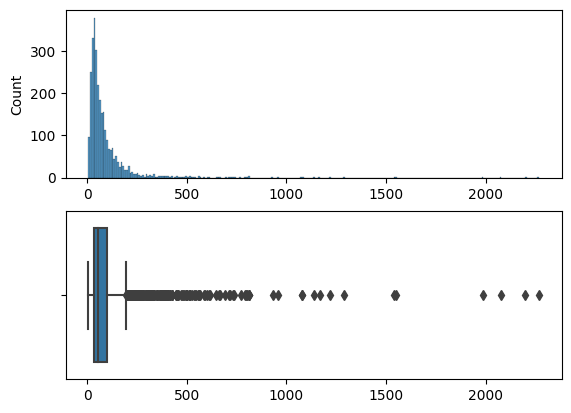

count    2964.000000
mean       91.368421
std       136.801247
min         5.000000
25%        34.000000
50%        55.500000
75%        99.000000
max      2268.000000
dtype: float64

In [ ]:
temp = [len(x) for x in ids_train]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

In [ ]:
MAX_LEN = 200 # 최대 길이
pad_train = pad_sequences(
    ids_train, maxlen=MAX_LEN, dtype="long", padding="post", truncating="post"
)

In [ ]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_train, y_train.values, random_state=2023, test_size=0.1)

In [ ]:
# Attention Mask 만들기
# 단어 부분은 1, 0으로 패딩된 부분은 0
attention_masks_train = []
for seq in train_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_train.append(seq_mask)

attention_masks_val = []
for seq in val_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_val.append(seq_mask)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(attention_masks_train)
train_labels = torch.tensor(train_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(attention_masks_val)
val_labels = torch.tensor(val_labels)

In [ ]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
## Test Set 전처리

# [CLS] + 문장 + [SEP]
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in x_test]

# 라벨 데이터
labels = y_test.values

# Word 토크나이저 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 시퀀스 설정 및 정수 인덱스 변환 & 패딩
MAX_LEN = 200
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# 파이토치 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈 설정 및 데이터 설정
batch_size = 16
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# GPU 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
model = BertClassifier()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.cuda()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
# model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
# model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch.optim as optim
from transformers.optimization import Adafactor, AdafactorSchedule
# 옵티마이저
# optimizer = Adafactor(
#     model.parameters(),
#     lr=2e-5,
#     eps=(1e-30, 1e-3),
#     clip_threshold=1.0,
#     decay_rate=-0.8,
#     beta1=None,
#     weight_decay=0.0,
#     relative_step=False,
#     scale_parameter=False,
#     warmup_init=False,
# )
optimizer = Adafactor(model.parameters(),
                  lr = 2e-5, # 학습률(learning rate)
                  eps = (1e-8, 1e-7),
                  clip_threshold=1.0,
                  decay_rate=-0.8,
                  beta1=None,
                  weight_decay=0.0,
                  relative_step=False,
                  scale_parameter=False,
                  warmup_init=False,

                )

# 에폭수
epochs = 100

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 스케줄러 생성
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)

# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 0.95 ** epochs)

# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
#                                                 lr_lambda=lambda epoch: 0.95 ** epoch)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.00001, eps=1e-08, verbose=False)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 시각화를 위한 결과 값 저장
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

## Early Stopping
best_loss = 1e9
best_acc = 0  
patience_limit = 7  # 몇 번 지켜볼지
patience_check = 0   # 현재 몇 epoch 연속으로 개선이 안되는지 기록

#그래디언트 초기화
model.zero_grad()

# 학습
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()


    # 훈련모드로 변경
    model.train()
    
    # 변수 초기화
    train_accuracy, nb_train_steps = 0, 0
    # 로스 초기화
    total_loss = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm_notebook(train_dataloader)):
        # 경과 정보 표시
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        logits = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)
    
    # 평균 정확도 계산
    avg_train_acc = train_accuracy/nb_train_steps
    train_acc_list.append(avg_train_acc)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.4f}".format(avg_train_acc))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    val_loss, val_accuracy = 0, 0
    nb_val_steps =  0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in tqdm_notebook(val_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        # 출력 로짓 구함
        logits = outputs[1]

        # 총 로스 계산
        val_loss += loss.item()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_val_accuracy = flat_accuracy(logits, label_ids)
        val_accuracy += tmp_val_accuracy
        nb_val_steps += 1

    # 평균 로스 계산
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_list.append(avg_val_loss)
    
    # 평균 정확도 계산
    avg_val_acc = val_accuracy/nb_val_steps
    val_acc_list.append(avg_val_acc)
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation Accuracy: {0:.4f}".format(avg_val_acc))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Early Stopping
    if avg_val_loss > best_loss: # loss 개선 되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit:
            print("Early Stopping !!!")
            break
    else: # loss 개선
        best_loss = avg_val_loss
        patience_check = 0
    # # Early Stopping
    # if avg_val_acc < best_acc: # accuracy 개선 되지 않은 경우
    #     patience_check += 1
    #     if patience_check >= patience_limit:
    #         print("Early Stopping !!!")
    #         break
    # else: # accuracy 개선
    #     best_acc = avg_val_acc
    #     patience_check = 0

print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

TypeError: ignored

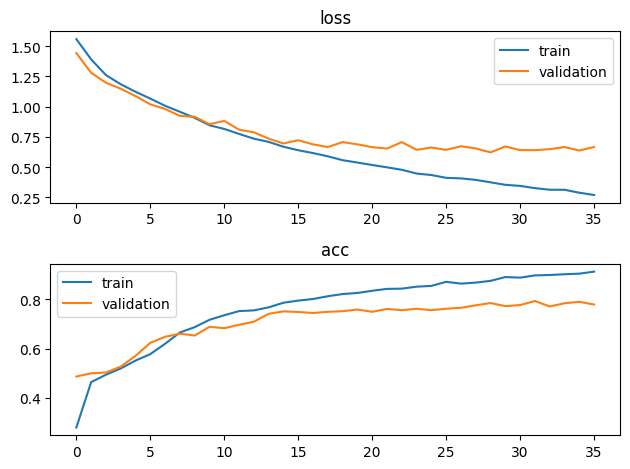

In [ ]:
plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('acc')
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='validation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## Test Set
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 출력 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.79
Test took: 0:00:01


In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):
    # [CLS] + 문장 + [SEP]
    sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 200

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

def test_sentences(sentences):
    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 출력 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
y_pred = test_sentences(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(confusion_matrix(y_test, y_pred.argmax(axis=1)))
print(classification_report(y_test, y_pred.argmax(axis=1)))
print(f1_score(y_test, y_pred.argmax(axis=1), average='macro'))

[[269  15  25   8   0]
 [ 13 123   4   7   0]
 [ 29   6 104   7   0]
 [  4   6   4  98   0]
 [  1  19   0   0   0]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       317
           1       0.73      0.84      0.78       147
           2       0.76      0.71      0.73       146
           3       0.82      0.88      0.84       112
           4       0.00      0.00      0.00        20

    accuracy                           0.80       742
   macro avg       0.63      0.65      0.64       742
weighted avg       0.78      0.80      0.79       742

0.6416423884158107
